<a href="https://colab.research.google.com/github/muniznicole/basic_crud_django/blob/main/Coleta_de_emails_SuporteDTI_Contexto_Nuvem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ETAPA 1: COLETA DE DADOS

In [ ]:
# Montar o drive
from google.colab import drive
drive.mount('/content/drive')

# Carregar o arquivo CSV diretamente
import pandas as pd
df_2021 = pd.read_csv('/content/drive/MyDrive/Coleta_de_emails_Nicole/Coleta_de_emails_SuporteDTI_completa/Coleta_de_emails_SuporteDTI2021.csv')
df_2022 = pd.read_csv('/content/drive/MyDrive/Coleta_de_emails_Nicole/Coleta_de_emails_SuporteDTI_completa/Coleta_de_emails_SuporteDTI2022.csv')
df_2023 = pd.read_csv('/content/drive/MyDrive/Coleta_de_emails_Nicole/Coleta_de_emails_SuporteDTI_completa/Coleta_de_emails_SuporteDTI2023.csv')

Mounted at /content/drive


# ETAPA 2: PRÉ-PROCESSAMENTO DOS DADOS E TÓPICOS FREQUENTES

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Downloads necessários para NLTK
nltk.download('punkt_tab')
nltk.download('stopwords')

# Carregar stopwords em português e adicionar mais palavras irrelevantes para e-mails
stop_words = set(stopwords.words('portuguese'))
stop_words.update([
    'boa', 'bom', 'tarde', 'dia', 'olá', 'prezados', '-', ',', '.', '!', '?',
    'sr', 'sra', 'senhor', 'senhora', 'atenciosamente', 'unitins', 'br', 'fwd', 're',
    'http', 'https', 'att', 'message', 'forwarded', 'image', 'rogerio', 'rogério', 'lopes', 'ferreira'
    'subject', 'universidade', 'estadual', 'tocantins'
])

# Função de pré-processamento para remover stopwords e pontuações
def preprocess(text):
    if isinstance(text, str):  # Verifica se o texto é uma string
        # Tokenizar
        tokens = word_tokenize(text.lower())
        # Remover stopwords e manter apenas palavras alfabéticas
        tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
        return ' '.join(tokens)
    else:
        return ''  # Retorna uma string vazia para valores não-string

# Remover linhas com dados faltantes nas colunas de interesse e aplicar pré-processamento
for df in [df_2021, df_2022, df_2023]:
    df.dropna(subset=['Assunto', 'Corpo do E-mail (Resumo)'], inplace=True)
    # Criar as colunas de texto processado
    df['processed_subject'] = df['Assunto'].apply(preprocess)
    df['processed_body'] = df['Corpo do E-mail (Resumo)'].apply(preprocess)

# Análise de Tópicos com KMeans usando TF-IDF
def analyze_topics_kmeans(df, num_clusters=5):
    # Juntar textos de assunto e corpo do e-mail já processados
    df['combined_text'] = df['processed_subject'] + " " + df['processed_body']

    # Criar vetor TF-IDF sem stopwords, pois elas já foram removidas
    vectorizer = TfidfVectorizer(max_df=0.5, min_df=2)
    tfidf_matrix = vectorizer.fit_transform(df['combined_text'])

    # Aplicar KMeans para agrupar os tópicos
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)

    # Associar os clusters aos e-mails
    df['cluster'] = kmeans.labels_

    return kmeans, vectorizer, tfidf_matrix, df

# Aplicar a função para cada ano
kmeans_2021, vectorizer_2021, tfidf_2021, df_2021 = analyze_topics_kmeans(df_2021)
kmeans_2022, vectorizer_2022, tfidf_2022, df_2022 = analyze_topics_kmeans(df_2022)
kmeans_2023, vectorizer_2023, tfidf_2023, df_2023 = analyze_topics_kmeans(df_2023)

# Função para exibir os clusters e palavras associadas
def print_clusters(kmeans, vectorizer, num_words=5):
    terms = vectorizer.get_feature_names_out()
    for i, center in enumerate(kmeans.cluster_centers_):
        print(f"Cluster {i + 1}:")
        words = [terms[ind] for ind in center.argsort()[-num_words:]]
        print(", ".join(words))

print("Tópicos para 2021:")
print_clusters(kmeans_2021, vectorizer_2021)

print("Tópicos para 2022:")
print_clusters(kmeans_2022, vectorizer_2022)

print("Tópicos para 2023:")
print_clusters(kmeans_2023, vectorizer_2023)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Tópicos para 2021:
Cluster 1:
sgd, cpf, email, curso, acesso
Cluster 2:
acesso, acessar, aluno, portal, senha
Cluster 3:
fiscal, fazer, prova, vestibular, inscrição
Cluster 4:
viemos, tech, cadastro, cadun, sistema
Cluster 5:
atualização, novo, chamado, error, glpi
Tópicos para 2022:
Cluster 1:
matrícula, cpf, email, acesso, curso
Cluster 2:
vestibular, solicito, inscrição, acesso, sgd
Cluster 3:
conseguindo, acesso, acessar, aluno, portal
Cluster 4:
tech, reprove, cadastro, cadun, sistema
Cluster 5:
acesso, recuperação, esqueci, recuperar, senha
Tópicos para 2023:
Cluster 1:
viemos, aprove, reprove, suporte, cadun
Cluster 2:
solicito, cpf, curso, senha, acesso
Cluster 3:
institucional, senha, novo, alteração, email
Cluster 4:
acesso, conseguindo, acessar, aluno, portal
Cluster 5:
acesso, novo, error, chamado, glpi


# Nuvem de palavras combinando os clusters por ano

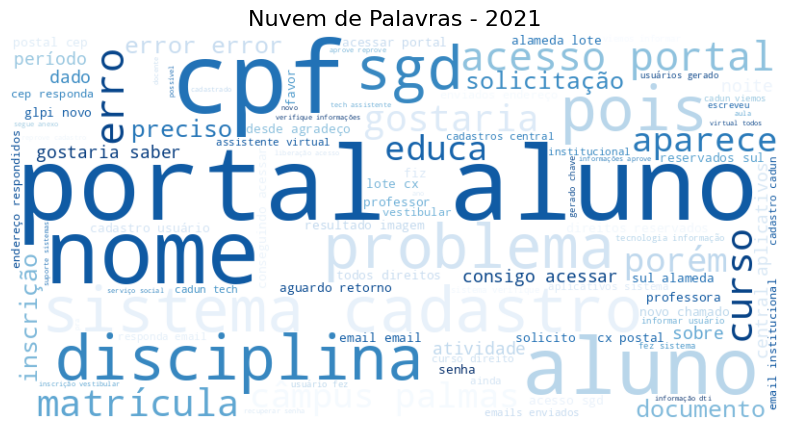

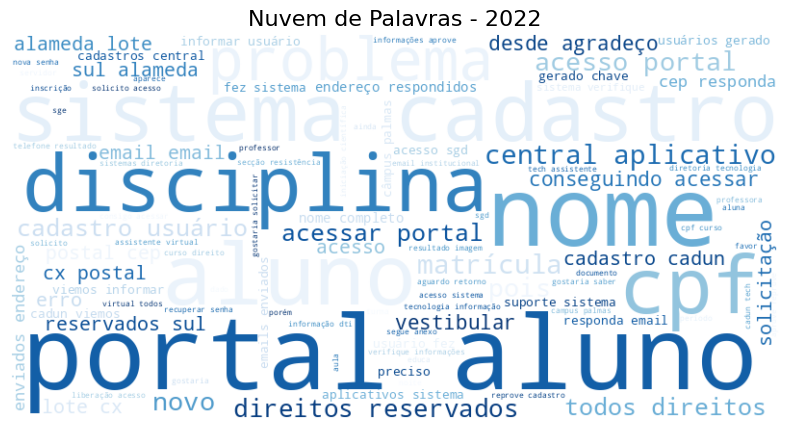

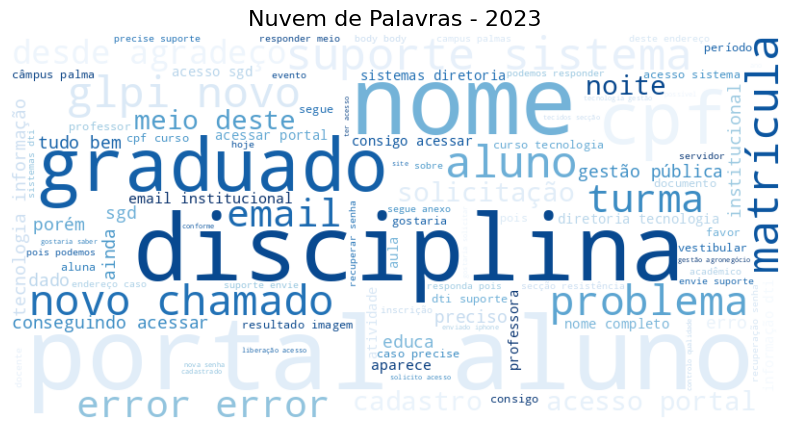

In [ ]:
# Importar as bibliotecas necessárias
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Função para gerar a nuvem de palavras por ano
def gerar_wordcloud_por_ano(df, ano):
    # Juntar todos os e-mails processados (assunto + corpo) em um único texto
    texto = ' '.join(df['processed_subject'].values) + ' ' + ' '.join(df['processed_body'].values)

    # Gerar a nuvem de palavras
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, colormap='Blues').generate(texto)

    # Plotar a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuvem de Palavras - {ano}', fontsize=16)
    plt.show()

# Exemplo de chamada para gerar as nuvens para os anos de 2021, 2022 e 2023
# df_2021, df_2022, df_2023 são os DataFrames que contêm os dados dos respectivos anos,
# com as colunas 'processed_subject' e 'processed_body' já processadas.

gerar_wordcloud_por_ano(df_2021, 2021)
gerar_wordcloud_por_ano(df_2022, 2022)
gerar_wordcloud_por_ano(df_2023, 2023)

# ETAPA 3: IDENTIFICAÇÃO DOS PROBLEMAS RECORRENTES

In [ ]:
from collections import Counter

def extrair_topicos_por_cluster(df, vectorizer, kmeans, num_palavras=5):
    """
    Extrai as palavras mais relevantes de cada cluster.
    """
    termos = vectorizer.get_feature_names_out()
    topicos_por_cluster = []

    # Iterar pelos clusters e extrair as palavras mais importantes
    for i in range(kmeans.n_clusters):
        palavras_cluster = [termos[ind] for ind in kmeans.cluster_centers_[i].argsort()[-num_palavras:]]
        topicos_por_cluster.extend(palavras_cluster)

    return topicos_por_cluster

# Aplicar a extração para cada ano
topicos_2021 = extrair_topicos_por_cluster(df_2021, vectorizer_2021, kmeans_2021)
topicos_2022 = extrair_topicos_por_cluster(df_2022, vectorizer_2022, kmeans_2022)
topicos_2023 = extrair_topicos_por_cluster(df_2023, vectorizer_2023, kmeans_2023)

# Unir os tópicos de todos os anos
todos_topicos = topicos_2021 + topicos_2022 + topicos_2023

# Contar a frequência das palavras e obter os 10 principais tópicos
from collections import Counter

frequencia_topicos = Counter(todos_topicos)
principais_problemas = frequencia_topicos.most_common(10)

# Exibir os 10 principais problemas
print("Os 10 principais problemas considerando os 3 anos:")
for problema, freq in principais_problemas:
    print(f"{problema}: {freq} ocorrências")

Os 10 principais problemas considerando os 3 anos:
acesso: 9 ocorrências
senha: 4 ocorrências
cpf: 3 ocorrências
email: 3 ocorrências
curso: 3 ocorrências
acessar: 3 ocorrências
aluno: 3 ocorrências
portal: 3 ocorrências
cadun: 3 ocorrências
novo: 3 ocorrências


# Nuvem de palavras dos principais problemas

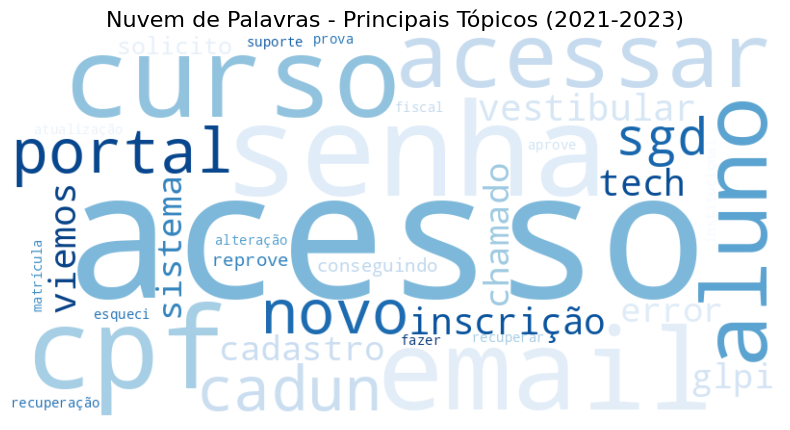

In [ ]:
# Importar as bibliotecas necessárias
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Função para gerar a nuvem de palavras com base nos tópicos frequentes
def gerar_wordcloud_topicos(frequencia_topicos):
    # Gerar a nuvem de palavras baseada na frequência
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, colormap='Blues').generate_from_frequencies(frequencia_topicos)

    # Plotar a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nuvem de Palavras - Principais Tópicos (2021-2023)', fontsize=16)
    plt.show()

# Aplicar a função para gerar a nuvem de palavras dos tópicos mais comuns
gerar_wordcloud_topicos(frequencia_topicos)

# ANÁLISE DE CONTEXTO

In [ ]:
def encontrar_coocorrencias_global(dfs, palavra_alvo, frequencia_minima=3):
    """
    Encontra as palavras mais comuns que aparecem junto com a palavra-alvo
    considerando os dados dos três anos combinados.
    """
    coocorrencias = Counter()

    # Iterar por todas as entradas dos três anos combinados
    for df in dfs:
        for texto in df['combined_text']:
            palavras = texto.split()
            if palavra_alvo in palavras:
                # Adicionar palavras relevantes, excluindo stopwords
                palavras_filtradas = [p for p in palavras if p not in stop_words and p != palavra_alvo]
                coocorrencias.update(palavras_filtradas)

    # Retornar no máximo 5 palavras mais comuns que co-ocorrem com a palavra-alvo
    return coocorrencias.most_common(5)

def encontrar_problemas_com_contexto_global(principais_problemas, dfs):
    """
    Identifica os principais problemas e mostra o contexto relevante considerando
    todos os anos combinados.
    """
    print("Principais problemas com contexto (Análise Global):")
    for palavra, freq in principais_problemas:
        print(f"\nProblema: {palavra} ({freq} ocorrências)")
        contexto = encontrar_coocorrencias_global(dfs, palavra)
        print("Contexto:", contexto)

# Consolidar os DataFrames dos três anos
dfs = [df_2021, df_2022, df_2023]

# Aplicar a análise de contexto global
encontrar_problemas_com_contexto_global(principais_problemas, dfs)

Principais problemas com contexto (Análise Global):

Problema: acesso (9 ocorrências)
Contexto: [('senha', 1550), ('cpf', 1483), ('portal', 1185), ('curso', 1138), ('aluno', 957)]

Problema: senha (4 ocorrências)
Contexto: [('acesso', 1367), ('cpf', 893), ('portal', 860), ('email', 766), ('acessar', 712)]

Problema: cpf (3 ocorrências)
Contexto: [('acesso', 2176), ('senha', 1258), ('curso', 1098), ('nome', 1074), ('portal', 901)]

Problema: email (3 ocorrências)
Contexto: [('sistema', 1061), ('acesso', 976), ('senha', 950), ('cadastro', 884), ('curso', 699)]

Problema: curso (3 ocorrências)
Contexto: [('acesso', 1328), ('cpf', 1029), ('portal', 876), ('aluno', 806), ('nome', 782)]

Problema: acessar (3 ocorrências)
Contexto: [('senha', 1022), ('acesso', 999), ('portal', 927), ('aluno', 753), ('cpf', 604)]

Problema: aluno (3 ocorrências)
Contexto: [('portal', 1520), ('acesso', 1018), ('senha', 804), ('curso', 684), ('cpf', 652)]

Problema: portal (3 ocorrências)
Contexto: [('aluno', 15

# Nuvem de palavras de coocorrências de cada problema

In [ ]:
import pandas as pd

def exibir_contexto_tabela(contexto, palavra_alvo):
    # Converter contexto em um DataFrame
    contexto_df = pd.DataFrame(contexto, columns=['Palavra', 'Frequência'])
    contexto_df['Palavra-Alvo'] = palavra_alvo

    # Exibir a tabela
    print(contexto_df)

def encontrar_problemas_com_contexto_global(principais_problemas, dfs):
    """
    Identifica os principais problemas e mostra o contexto relevante considerando
    todos os anos combinados.
    """
    print("Principais problemas com contexto (Análise Global):")
    for palavra, freq in principais_problemas:
        print(f"\nProblema: {palavra} ({freq} ocorrências)")
        contexto = encontrar_coocorrencias_global(dfs, palavra)

        # Exibir o contexto em forma de tabela
        exibir_contexto_tabela(contexto, palavra)

# Consolidar os DataFrames dos três anos
dfs = [df_2021, df_2022, df_2023]

# Aplicar a análise de contexto global
encontrar_problemas_com_contexto_global(principais_problemas, dfs)

Principais problemas com contexto (Análise Global):

Problema: acesso (9 ocorrências)
  Palavra  Frequência Palavra-Alvo
0   senha        1550       acesso
1     cpf        1483       acesso
2  portal        1185       acesso
3   curso        1138       acesso
4   aluno         957       acesso

Problema: senha (4 ocorrências)
   Palavra  Frequência Palavra-Alvo
0   acesso        1367        senha
1      cpf         893        senha
2   portal         860        senha
3    email         766        senha
4  acessar         712        senha

Problema: cpf (3 ocorrências)
  Palavra  Frequência Palavra-Alvo
0  acesso        2176          cpf
1   senha        1258          cpf
2   curso        1098          cpf
3    nome        1074          cpf
4  portal         901          cpf

Problema: email (3 ocorrências)
    Palavra  Frequência Palavra-Alvo
0   sistema        1061        email
1    acesso         976        email
2     senha         950        email
3  cadastro         884        em

# ANÁLISE DE SENTIMENTO

In [ ]:
from textblob import TextBlob

def analisar_sentimento(text):
    blob = TextBlob(text)
    polaridade = blob.sentiment.polarity  # Valor entre -1 (negativo) e 1 (positivo)
    return 'Positivo' if polaridade > 0 else 'Negativo' if polaridade < 0 else 'Neutro'

# Aplicar a análise de sentimento nas colunas de texto combinado
for df in [df_2021, df_2022, df_2023]:
    df['sentimento'] = df['combined_text'].apply(analisar_sentimento)

# Exibir distribuição de sentimentos por ano
for ano, df in zip([2021, 2022, 2023], [df_2021, df_2022, df_2023]):
    print(f"\nDistribuição de sentimentos em {ano}:")
    print(df['sentimento'].value_counts())


Distribuição de sentimentos em 2021:
sentimento
Neutro      2961
Positivo     220
Negativo     129
Name: count, dtype: int64

Distribuição de sentimentos em 2022:
sentimento
Neutro      3355
Negativo     178
Positivo     169
Name: count, dtype: int64

Distribuição de sentimentos em 2023:
sentimento
Neutro      3912
Positivo     325
Negativo     144
Name: count, dtype: int64


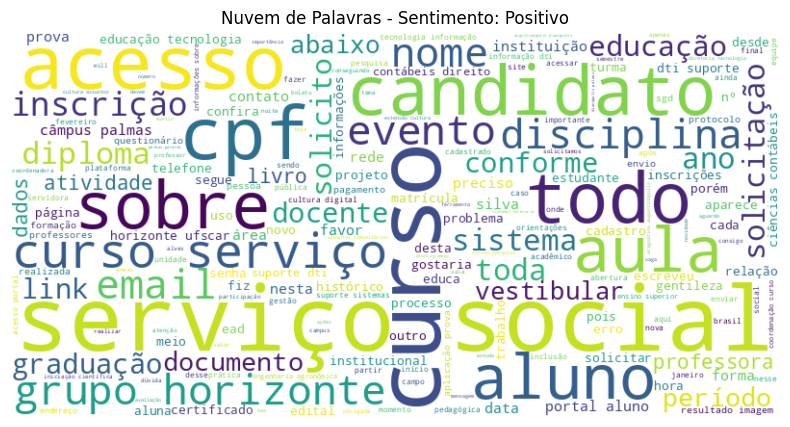

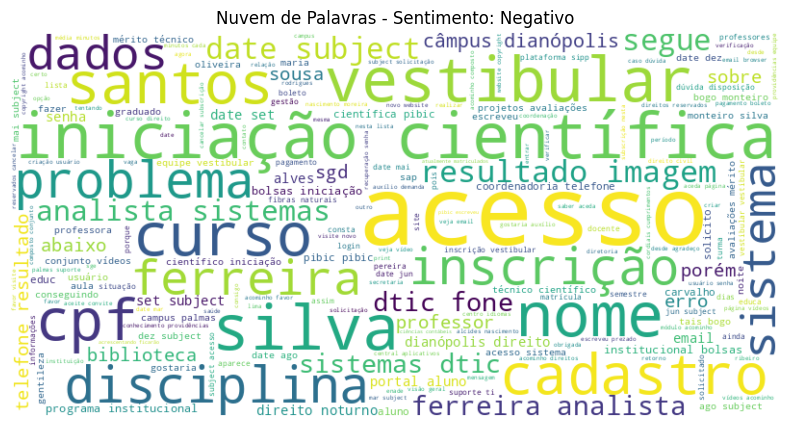

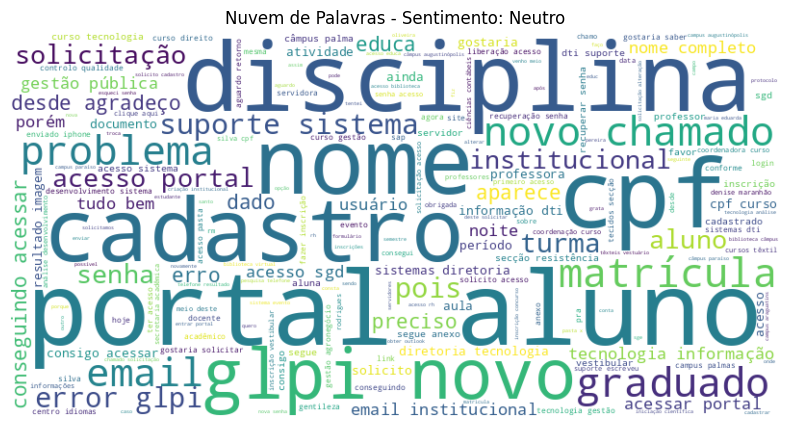

In [ ]:
def gerar_wordcloud_por_sentimento(df, sentimento):
    textos = df[df['sentimento'] == sentimento]['combined_text']
    texto_concatenado = ' '.join(textos)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_concatenado)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuvem de Palavras - Sentimento: {sentimento}')
    plt.show()

# Exemplo: Gerar nuvem de palavras para sentimento positivo
gerar_wordcloud_por_sentimento(df_2021, 'Positivo')
gerar_wordcloud_por_sentimento(df_2022, 'Negativo')
gerar_wordcloud_por_sentimento(df_2023, 'Neutro')

#TENDÊNCIAS TEMPORAIS

<ipython-input-8-6c89aab65210>:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Data'] = pd.to_datetime(df['Data'])
<ipython-input-8-6c89aab65210>:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Data'] = pd.to_datetime(df['Data'])
<ipython-input-8-6c89aab65210>:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Data'] = pd.to_datetime(df['Data'])


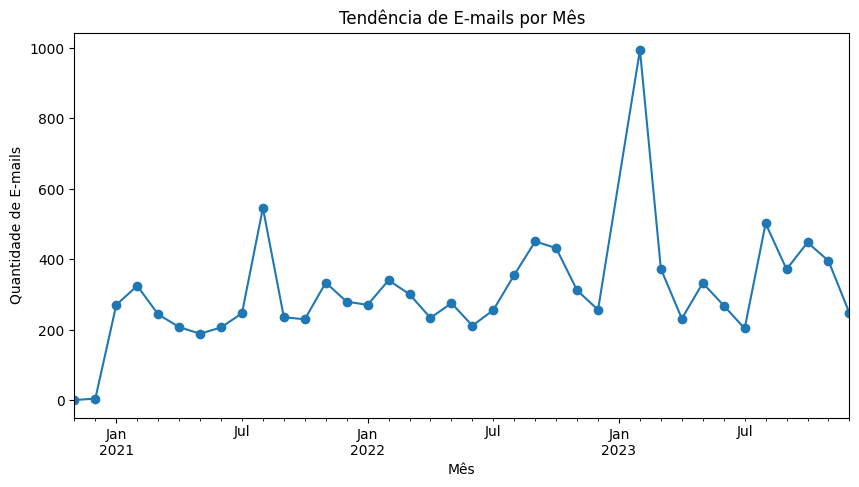

In [ ]:
# Converter a coluna de Data para datetime e extrair mês e ano
for df in [df_2021, df_2022, df_2023]:
    df['Data'] = pd.to_datetime(df['Data'])
    df['mes'] = df['Data'].dt.to_period('M')

# Contar frequência dos e-mails por mês
df_frequencia = pd.concat([df_2021, df_2022, df_2023]).groupby('mes').size()

# Plotar a tendência de e-mails recebidos por mês
import matplotlib.pyplot as plt

df_frequencia.plot(kind='line', figsize=(10, 5), marker='o', title='Tendência de E-mails por Mês')
plt.xlabel('Mês')
plt.ylabel('Quantidade de E-mails')
plt.show()

# ANÁLISE DE CORRESPONDÊNCIA ENTRE ASSUNTO E CORPO DO E-MAIL


In [ ]:
def gerar_relatorio_divergencias(df, ano):
    num_divergentes = len(df[df['processed_subject'] != df['processed_body']])
    print(f"\nRelatório de Divergências em {ano}:")
    print(f"Total de e-mails divergentes: {num_divergentes}")

# Gerar o relatório para cada ano
gerar_relatorio_divergencias(df_2021, 2021)
gerar_relatorio_divergencias(df_2022, 2022)
gerar_relatorio_divergencias(df_2023, 2023)


Relatório de Divergências em 2021:
Total de e-mails divergentes: 3301

Relatório de Divergências em 2022:
Total de e-mails divergentes: 3691

Relatório de Divergências em 2023:
Total de e-mails divergentes: 4370
